In [25]:
import h5py
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm.keras import TqdmCallback

from src.data.loaders import aisy
from src.data.preprocess.hw import full_states, hamming_weights
from src.dlla.hw import prepare_traces_dl, dlla_hw
from src.dlla.model9 import make_model_9
from src.tools.cache import cache_np
import seaborn as sns

In [3]:
TRACES = cache_np("aisy_traces")

In [4]:
IN_FILE = h5py.File(aisy.aes.tvla, "r")
# TRACES = np.array(IN_FILE['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = IN_FILE['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]
PLAINTEXT = IN_FILE['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = IN_FILE['traces_group/metadata']['ciphertext'].astype(int)
KEY = IN_FILE['traces_group/metadata']['key'].astype(int)

In [5]:
PROFILING_MASK = np.ones(len(TRACES), dtype=bool)
PROFILING_MASK[2::3] = 0

In [6]:
STATES = full_states(PLAINTEXT, KEY)

100%|██████████| 10000/10000 [00:03<00:00, 2541.01it/s]


In [7]:
TARGET_ROUND = 4 # Fifth round
TARGET_BIT = 0

TARGET_STATE = STATES[:, TARGET_ROUND, TARGET_BIT]
HWS = hamming_weights(TARGET_STATE)

In [8]:
X, Y = TRACES[PROFILING_MASK], HWS[PROFILING_MASK]
X_ATT, Y_ATT = TRACES[~PROFILING_MASK], HWS[~PROFILING_MASK]

In [9]:
X9, Y9, X9_ATT, Y9_ATT = prepare_traces_dl(X, Y, X_ATT, Y_ATT)

In [29]:
def build_mlp(x, y, params):
    mdl = Sequential()
    mdl.add(Dense(200, activation=params['activation'], input_shape=(x.shape[1],)))
    mdl.add(Dense(9, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, batch_size=params['batch_size'], epochs=params['epochs'])

    return out, mdl

def make_model_mini(x, y):
    return build_mlp(x, y, {
        'activation': 'relu',
        'optimizer': Adam(learning_rate=0.001),
        'losses': 'categorical_crossentropy',
        'batch_size': 200,
        'epochs': 100,
    })[1]

In [30]:
MDL9 = make_model_mini(X9, Y9)
DLLA9_P = dlla_hw(MDL9, X9_ATT, Y9_ATT)

DLLA9_P

Epoch 1/100
34/34 [==============================] - 7s 185ms/step - loss: 38.8977 - accuracy: 0.4201

6.59909476183413e-308

In [ ]:
MAX_WEIGHT = np.max(np.abs(MDL9.get_weights()[0]), axis=1)

<AxesSubplot:>

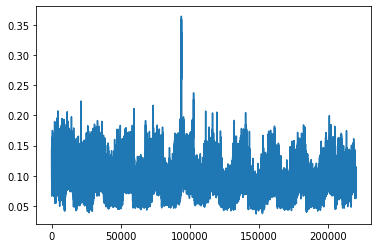

In [35]:
sns.lineplot(data=cache_np("max_weight_100_epochs"))